# 4 Features Model

Este notebook implementa un modelo que utiliza exactamente 4 features generadas mediante técnicas de stacking (meta-features).
El objetivo es lograr un F1-Score > 0.8 utilizando solo estas 4 features.

## Imports

In [2]:
# Standard
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# ML
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score

# DL (BERT)
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, logging
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

warnings.filterwarnings("ignore")
logging.set_verbosity_error()

c:\Users\maxim\cdd-martinelli\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constantes

In [3]:
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

SEED = 42

## Datos

In [4]:
data_path = pathlib.Path("../.data/raw")
df = pd.read_csv(data_path / "train.csv")
test_df = pd.read_csv(data_path / "test.csv")

In [5]:
target_mean = df['target'].mean()
print(f'Shape del dataset: {df.shape}')
print(f'Porcentaje de desastres en el target: {target_mean*100:.2f}%')
df.sample(5, random_state=SEED)

Shape del dataset: (7613, 5)
Porcentaje de desastres en el target: 42.97%


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


## Feature Engineering (Generación de 4 Meta-Features)

Vamos a generar 4 features basadas en modelos simples (stacking):
1. **Keyword Target Encoding**: Probabilidad de desastre dada la keyword.
2. **BERT Probability**: Probabilidad de desastre usando DistilBERT (Fine-tuned).
3. **Logistic Regression Probability (Words)**: Probabilidad usando LR sobre TF-IDF (Words).
4. **Logistic Regression Probability (Chars)**: Probabilidad usando LR sobre TF-IDF (Chars).

In [6]:
# Limpieza básica
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['clean_text'] = df['text'].fillna('').apply(clean_text)
test_df['clean_text'] = test_df['text'].fillna('').apply(clean_text)
df['keyword'] = df['keyword'].fillna('unknown')
test_df['keyword'] = test_df['keyword'].fillna('unknown')

y = df['target'].values

# Stratified K-Fold para generar features sin leakage
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [7]:
# --- Feature 1: Keyword Target Encoding ---
print("Generando Feature 1: Keyword Target Encoding...")
oof_keyword = pd.Series(0.0, index=df.index)
test_keyword = pd.Series(0.0, index=test_df.index)

# Para train (CV)
for train_idx, val_idx in skf.split(df, y):
    X_tr, X_val = df.iloc[train_idx], df.iloc[val_idx]
    y_tr = y[train_idx]
    
    mean_target = y_tr.mean()
    agg = X_tr.groupby('keyword')['target'].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    weight = counts / (counts + 2)
    smooth_means = weight * means + (1 - weight) * mean_target
    
    oof_keyword.iloc[val_idx] = X_val['keyword'].map(smooth_means).fillna(mean_target)

# Para test (entrenado con todo train)
mean_target = y.mean()
agg = df.groupby('keyword')['target'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']
weight = counts / (counts + 2)
smooth_means = weight * means + (1 - weight) * mean_target
test_keyword = test_df['keyword'].map(smooth_means).fillna(mean_target)

Generando Feature 1: Keyword Target Encoding...


In [8]:
# --- Feature 2: BERT Probability ---
print("Generando Feature 2: BERT Probability...")

# Configuración GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Usando GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("ADVERTENCIA: No se detectó GPU. El entrenamiento de BERT será lento.")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def encode_data(texts, max_len=64):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

Generando Feature 2: BERT Probability...
Usando GPU: NVIDIA GeForce RTX 4070
Usando GPU: NVIDIA GeForce RTX 4070


In [9]:
# Arrays para OOF y Test
oof_bert = np.zeros(len(df))
test_bert_preds = np.zeros(len(test_df))

# Encode Test Data once
input_ids_test, masks_test = encode_data(test_df['clean_text'].values)
test_dataset = TensorDataset(torch.tensor(input_ids_test), torch.tensor(masks_test))
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

# CV Loop for BERT
for fold, (train_idx, val_idx) in enumerate(skf.split(df, y)):
    print(f"  Entrenando BERT Fold {fold+1}...")
    
    # Prepare data
    X_tr_txt = df['clean_text'].iloc[train_idx].values
    X_val_txt = df['clean_text'].iloc[val_idx].values
    y_tr = y[train_idx]
    y_val = y[val_idx]
    
    input_ids_tr, masks_tr = encode_data(X_tr_txt)
    input_ids_val, masks_val = encode_data(X_val_txt)
    
    train_data = TensorDataset(torch.tensor(input_ids_tr), torch.tensor(masks_tr), torch.tensor(y_tr))
    val_data = TensorDataset(torch.tensor(input_ids_val), torch.tensor(masks_val), torch.tensor(y_val))
    
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)
    
    # Model
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    epochs = 2
    
    # Train
    for epoch in range(epochs):
        model.train()
        for batch in train_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
    # Predict OOF
    model.eval()
    preds_fold = []
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]
        preds_fold.extend(probs)
    
    oof_bert[val_idx] = np.array(preds_fold)
    
    # Predict Test (Average over folds)
    preds_test_fold = []
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]
        preds_test_fold.extend(probs)
        
    test_bert_preds += np.array(preds_test_fold) / skf.get_n_splits()
    
    del model, optimizer, train_dataloader, val_dataloader
    torch.cuda.empty_cache()

  Entrenando BERT Fold 1...
  Entrenando BERT Fold 2...
  Entrenando BERT Fold 2...
  Entrenando BERT Fold 3...
  Entrenando BERT Fold 3...
  Entrenando BERT Fold 4...
  Entrenando BERT Fold 4...
  Entrenando BERT Fold 5...
  Entrenando BERT Fold 5...


In [10]:
# --- Feature 3: LR Probability (Words) ---
print("Generando Feature 3: LR Probability (Words)...")
vec_lr = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=2, max_features=5000)
X_lr = vec_lr.fit_transform(df['clean_text'])
X_lr_test = vec_lr.transform(test_df['clean_text'])

lr = LogisticRegression(C=1.0, solver='liblinear', random_state=SEED)
oof_lr_word = cross_val_predict(lr, X_lr, y, cv=skf, method='predict_proba')[:, 1]
lr.fit(X_lr, y)
test_lr_word = lr.predict_proba(X_lr_test)[:, 1]

Generando Feature 3: LR Probability (Words)...


In [11]:
# --- Feature 4: LR Probability (Chars) ---
print("Generando Feature 4: LR Probability (Chars)...")
vec_char = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 6), min_df=3, max_features=3000)
X_char = vec_char.fit_transform(df['clean_text'])
X_char_test = vec_char.transform(test_df['clean_text'])

lr_char = LogisticRegression(C=1.0, solver='liblinear', random_state=SEED)
oof_lr_char = cross_val_predict(lr_char, X_char, y, cv=skf, method='predict_proba')[:, 1]
lr_char.fit(X_char, y)
test_lr_char = lr_char.predict_proba(X_char_test)[:, 1]

Generando Feature 4: LR Probability (Chars)...


In [12]:
# Dataset Final de 4 Features
X_train_meta = pd.DataFrame({
    'keyword_te': oof_keyword,
    'bert_prob': oof_bert,
    'lr_word_prob': oof_lr_word,
    'lr_char_prob': oof_lr_char
})

X_test_meta = pd.DataFrame({
    'keyword_te': test_keyword,
    'bert_prob': test_bert_preds,
    'lr_word_prob': test_lr_word,
    'lr_char_prob': test_lr_char
})

print(f'Shape de X_train_meta: {X_train_meta.shape}')
X_train_meta.head()

Shape de X_train_meta: (7613, 4)


,keyword_te,bert_prob,lr_word_prob,lr_char_prob
0,0.651143,0.823629,0.697903,0.320056
1,0.691002,0.964923,0.848002,0.873134
2,0.691002,0.847621,0.541026,0.755766
3,0.691002,0.987274,0.896617,0.984108
4,0.642905,0.985720,0.293914,0.720718


## Entrenamiento del modelo final

In [13]:
# Modelo final: Random Forest sobre las 4 features
rf = RandomForestClassifier(random_state=SEED)

param_distributions = {
    "n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, None],
    "min_samples_split": [1, 2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions,
    n_iter=200,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=SEED
)

random_search.fit(X_train_meta, y)

print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Mejor F1 Score (CV): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores parámetros: {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Mejor F1 Score (CV): 0.7904
Mejores parámetros: {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Mejor F1 Score (CV): 0.7904


## Análisis Final

Best F1 Threshold: 0.3800 (F1: 0.7952)


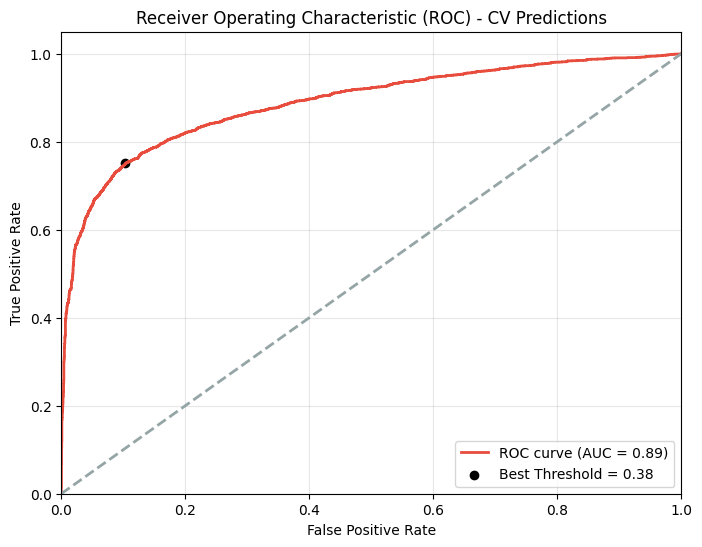

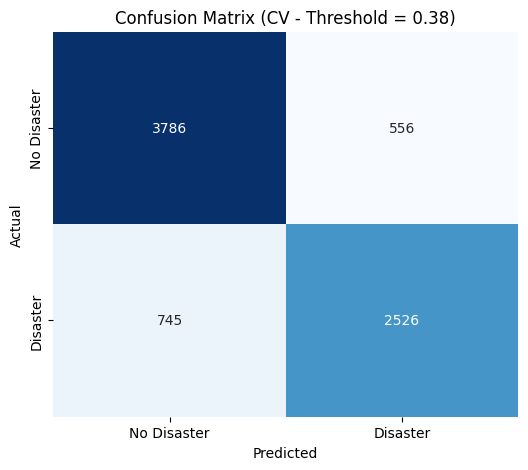

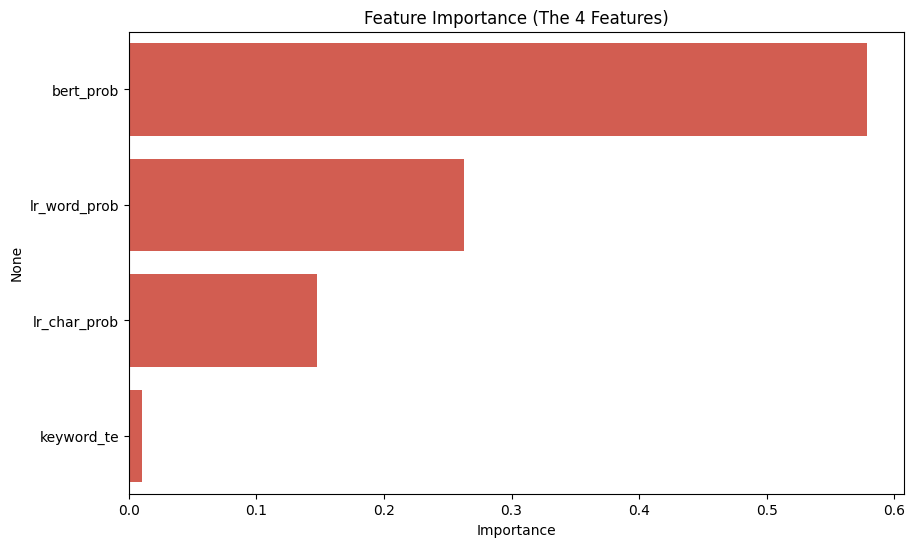

In [ ]:
best_model = random_search.best_estimator_

# Como usamos CV para generar las features, el score de CV es una buena estimación.
# Pero para graficar ROC y CM necesitamos predicciones.
# Podemos usar cross_val_predict sobre el modelo final.

y_probs_cv = cross_val_predict(best_model, X_train_meta, y, cv=skf, method='predict_proba')[:, 1]

# Optimizar threshold para maximizar F1
best_f1 = 0
best_thresh = 0.5
for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred_thresh = (y_probs_cv > thresh).astype(int)
    score = f1_score(y, y_pred_thresh)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh
print(f'Best F1 Threshold: {best_thresh:.4f} (F1: {best_f1:.4f})')

# 1. Curva ROC
fpr, tpr, thresholds = roc_curve(y, y_probs_cv)
roc_auc = auc(fpr, tpr)

# Mejor threshold según Youden's J
J = tpr - fpr
ix = np.argmax(J)
best_thresh_youden = thresholds[ix]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLOR_DISASTER, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLOR_GENERAL, lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - CV Predictions')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Matriz de Confusión
y_pred_opt = (y_probs_cv > best_thresh).astype(int)
cm = confusion_matrix(y, y_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=['No Disaster', 'Disaster'],
            yticklabels=['No Disaster', 'Disaster'])
plt.title(f'Confusion Matrix (CV - Threshold = {best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. Feature Importance
importances = best_model.feature_importances_
feature_names = X_train_meta.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], color=COLOR_DISASTER)
plt.title("Feature Importance (The 4 Features)")
plt.xlabel("Importance")
plt.show()

## Submission

In [15]:
# Re-entrenar con todo el dataset
best_model.fit(X_train_meta, y)

# Predecir en test
y_probs_sub = best_model.predict_proba(X_test_meta)[:, 1]
y_pred_sub = (y_probs_sub > best_thresh).astype(int)

submission = pd.DataFrame({'id': test_df['id'], 'target': y_pred_sub})

submission_path = pathlib.Path("../.data/submission")
submission_path.mkdir(parents=True, exist_ok=True)
submission.to_csv(submission_path / "4feats_submission.csv", index=False)

print(f"Submission guardada en {submission_path / '4feats_submission.csv'}")

Submission guardada en ..\.data\submission\4feats_submission.csv
